In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

In [4]:
def perform_eda(df):
    """Comprehensive Exploratory Data Analysis"""
    
    print("\n" + "="*60)
    print("EXPLORATORY DATA ANALYSIS (EDA)")
    print("="*60)
    
    # 1. Distribution Analysis
    print("\n1. DISTRIBUTION ANALYSIS")
    print("-" * 30)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Create subplots for distributions
    n_cols = len(numeric_cols)
    fig, axes = plt.subplots(nrows=(n_cols+2)//3, ncols=3, figsize=(15, 4*((n_cols+2)//3)))
    axes = axes.flatten() if n_cols > 3 else [axes]
    
    for i, col in enumerate(numeric_cols):
        if i < len(axes):
            df[col].hist(bins=30, ax=axes[i], alpha=0.7)
            axes[i].set_title(f'{col} Distribution')
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Frequency')
    
    # Remove empty subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.savefig('distributions.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 2. Correlation Analysis
    print("\n2. CORRELATION ANALYSIS")
    print("-" * 30)
    
    correlation_matrix = df[numeric_cols].corr()
    
    # Create correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Correlation Matrix of Numeric Variables')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Find high correlations
    high_corr = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i, j]) > 0.7:
                high_corr.append({
                    'Feature1': correlation_matrix.columns[i],
                    'Feature2': correlation_matrix.columns[j], 
                    'Correlation': correlation_matrix.iloc[i, j]
                })
    
    if high_corr:
        print("\nHigh Correlations (>0.7):")
        for corr in high_corr:
            print(f"   {corr['Feature1']} ↔ {corr['Feature2']}: {corr['Correlation']:.3f}")
    
    # 3. Time Series Analysis (if Year column exists)
    if 'Year' in df.columns:
        print("\n3. TIME SERIES TRENDS")
        print("-" * 30)
        
        yearly_trends = df.groupby('Year')[numeric_cols].mean()
        
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(numeric_cols):
            if col != 'Year':
                plt.subplot(3, 3, i+1)
                plt.plot(yearly_trends.index, yearly_trends[col], marker='o', linewidth=2)
                plt.title(f'{col} Trend Over Time')
                plt.xlabel('Year')
                plt.ylabel(col)
                plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('time_trends.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # 4. Outlier Detection
    print("\n4. OUTLIER DETECTION")
    print("-" * 30)
    
    outliers_summary = []
    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_count = len(outliers)
        outliers_percentage = (outliers_count / len(df)) * 100
        
        outliers_summary.append({
            'Column': col,
            'Outliers_Count': outliers_count,
            'Outliers_Percentage': outliers_percentage,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound
        })
    
    outliers_df = pd.DataFrame(outliers_summary)
    print(outliers_df.to_string(index=False))
    
    return correlation_matrix, outliers_df

In [5]:
def data_transformation(df):
    """Data cleaning and transformation"""
    
    print("\n" + "="*60)
    print("DATA TRANSFORMATION")
    print("="*60)
    
    df_transformed = df.copy()
    
    # 1. Handle missing values
    print("\n1. HANDLING MISSING VALUES")
    print("-" * 35)
    
    numeric_cols = df_transformed.select_dtypes(include=[np.number]).columns
    categorical_cols = df_transformed.select_dtypes(include=['object']).columns
    
    # Fill numeric missing values with median
    for col in numeric_cols:
        if df_transformed[col].isnull().sum() > 0:
            median_val = df_transformed[col].median()
            df_transformed[col].fillna(median_val, inplace=True)
            print(f"   {col}: Filled with median ({median_val:.2f})")
    
    # Fill categorical missing values with mode
    for col in categorical_cols:
        if df_transformed[col].isnull().sum() > 0:
            mode_val = df_transformed[col].mode()[0]
            df_transformed[col].fillna(mode_val, inplace=True)
            print(f"   {col}: Filled with mode ({mode_val})")
    
    # 2. Remove outliers (optional - using IQR method)
    print("\n2. OUTLIER TREATMENT")
    print("-" * 25)
    
    original_size = len(df_transformed)
    
    for col in numeric_cols:
        Q1 = df_transformed[col].quantile(0.25)
        Q3 = df_transformed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Cap outliers instead of removing them
        df_transformed[col] = np.clip(df_transformed[col], lower_bound, upper_bound)
    
    print(f"   Outliers capped using IQR method")
    print(f"   Dataset size maintained: {len(df_transformed)} rows")
    
    # 3. Feature Engineering
    print("\n3. FEATURE ENGINEERING")
    print("-" * 30)
    
    # Create new features based on existing ones
    if 'Temperature_Celsius' in df_transformed.columns:
        df_transformed['Temperature_Fahrenheit'] = df_transformed['Temperature_Celsius'] * 9/5 + 32
        print("   Created: Temperature_Fahrenheit")
    
    if 'CO2_Emissions_MtCO2' in df_transformed.columns and 'Year' in df_transformed.columns:
        df_transformed['CO2_Growth_Rate'] = df_transformed.groupby('Country')['CO2_Emissions_MtCO2'].pct_change()
        print("   Created: CO2_Growth_Rate")
    
    if 'Extreme_Weather_Events' in df_transformed.columns and 'Year' in df_transformed.columns:
        df_transformed['Weather_Events_MA'] = df_transformed.groupby('Country')['Extreme_Weather_Events'].rolling(window=3).mean().reset_index(0, drop=True)
        print("   Created: Weather_Events_MA (3-year moving average)")
    
    # Climate Risk Score (composite feature)
    if all(col in df_transformed.columns for col in ['Temperature_Celsius', 'Extreme_Weather_Events', 'Sea_Level_mm']):
        # Normalize components to 0-1 scale
        temp_norm = (df_transformed['Temperature_Celsius'] - df_transformed['Temperature_Celsius'].min()) / (df_transformed['Temperature_Celsius'].max() - df_transformed['Temperature_Celsius'].min())
        events_norm = (df_transformed['Extreme_Weather_Events'] - df_transformed['Extreme_Weather_Events'].min()) / (df_transformed['Extreme_Weather_Events'].max() - df_transformed['Extreme_Weather_Events'].min())
        sea_norm = (df_transformed['Sea_Level_mm'] - df_transformed['Sea_Level_mm'].min()) / (df_transformed['Sea_Level_mm'].max() - df_transformed['Sea_Level_mm'].min())
        
        df_transformed['Climate_Risk_Score'] = (temp_norm + events_norm + sea_norm) / 3
        print("   Created: Climate_Risk_Score (composite index)")
    
    return df_transformed

In [6]:
def feature_scaling(df_transformed):
    """Apply feature scaling"""
    
    print("\n4. FEATURE SCALING")
    print("-" * 25)
    
    numeric_cols = df_transformed.select_dtypes(include=[np.number]).columns
    df_scaled = df_transformed.copy()
    
    # Standard Scaling
    scaler = StandardScaler()
    df_scaled[numeric_cols] = scaler.fit_transform(df_transformed[numeric_cols])
    
    print("   Applied StandardScaler to all numeric features")
    print("   Features now have mean=0 and std=1")
    
    return df_scaled, scaler

In [7]:
def feature_selection(df_transformed, target_column=None):
    """Feature selection using multiple methods"""
    
    print("\n" + "="*60)
    print("FEATURE SELECTION")
    print("="*60)
    
    numeric_cols = df_transformed.select_dtypes(include=[np.number]).columns
    
    # If no target specified, use Climate_Risk_Score if available
    if target_column is None:
        if 'Climate_Risk_Score' in df_transformed.columns:
            target_column = 'Climate_Risk_Score'
        elif 'Temperature_Celsius' in df_transformed.columns:
            target_column = 'Temperature_Celsius'
        else:
            target_column = numeric_cols[0]
    
    print(f"Using '{target_column}' as target variable")
    
    # Prepare features and target
    X = df_transformed[numeric_cols].drop(columns=[target_column])
    y = df_transformed[target_column]
    
    # Remove any remaining NaN values
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]
    
    # 1. Correlation-based selection
    print("\n1. CORRELATION-BASED SELECTION")
    print("-" * 40)
    
    correlations = X.corrwith(y).abs().sort_values(ascending=False)
    high_corr_features = correlations[correlations > 0.3].index.tolist()
    
    print("Features with correlation > 0.3:")
    for feature in high_corr_features:
        print(f"   {feature}: {correlations[feature]:.3f}")
    
    # 2. Statistical selection (SelectKBest)
    print("\n2. STATISTICAL SELECTION (F-TEST)")
    print("-" * 40)
    
    selector = SelectKBest(score_func=f_regression, k=min(5, len(X.columns)))
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support()].tolist()
    feature_scores = selector.scores_
    
    print("Top 5 features by F-score:")
    for feature, score in zip(selected_features, feature_scores[selector.get_support()]):
        print(f"   {feature}: {score:.2f}")
    
    # 3. Random Forest Feature Importance
    print("\n3. RANDOM FOREST IMPORTANCE")
    print("-" * 35)
    
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("Feature importance ranking:")
    for _, row in feature_importance.head(5).iterrows():
        print(f"   {row['Feature']}: {row['Importance']:.3f}")
    
    # 4. PCA Analysis
    print("\n4. PRINCIPAL COMPONENT ANALYSIS")
    print("-" * 40)
    
    # Standardize features for PCA
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA()
    pca.fit(X_scaled)
    
    # Calculate cumulative explained variance
    cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1
    n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
    
    print(f"Components explaining 90% variance: {n_components_90}")
    print(f"Components explaining 95% variance: {n_components_95}")
    print("Top 3 components explain {:.1f}% of variance".format(cumsum_variance[2] * 100))
    
    # Create feature selection summary
    feature_selection_summary = {
        'high_correlation_features': high_corr_features,
        'statistical_features': selected_features,
        'rf_top_features': feature_importance.head(5)['Feature'].tolist(),
        'pca_components_90': n_components_90,
        'target_variable': target_column
    }
    
    return feature_selection_summary, feature_importance

In [8]:
def create_sample_data():
    """Create sample climate data"""
    print("Creating sample climate data...")
    
    np.random.seed(42)
    years = list(range(2000, 2025))
    countries = ['USA', 'China', 'India', 'Brazil', 'Russia', 'Japan']
    
    data = []
    for year in years:
        for country in countries:
            base_temp = np.random.normal(15, 5)
            temp_anomaly = (year - 2000) * 0.05 + np.random.normal(0, 0.5)
            
            row = {
                'Year': year,
                'Country': country,
                'Temperature_Celsius': base_temp + temp_anomaly,
                'CO2_Emissions_MtCO2': np.random.lognormal(8, 1),
                'Precipitation_mm': np.random.gamma(2, 400),
                'Sea_Level_mm': 1500 + (year - 2000) * 3.2 + np.random.normal(0, 10),
                'Extreme_Weather_Events': np.random.poisson(5),
                'Forest_Coverage_percent': max(0, 50 + np.random.normal(0, 20)),
                'Renewable_Energy_percent': min(100, max(0, (year - 2000) * 1.5 + np.random.normal(0, 5)))
            }
            
            if np.random.random() < 0.05:
                col_to_miss = np.random.choice(['CO2_Emissions_MtCO2', 'Forest_Coverage_percent'])
                row[col_to_miss] = np.nan
            
            data.append(row)
    
    df = pd.DataFrame(data)
    df.to_csv('sample_climate_data.csv', index=False)
    return df

In [9]:
def main():
    """Main analysis pipeline"""
    
    print("="*80)
    print("ENHANCED CLIMATE RISK ANALYSIS WITH EDA & FEATURE ENGINEERING")
    print("="*80)
    
    # Load data
    dataset_paths = ["climate_change_dataset.csv", "sample_climate_data.csv"]
    df = None
    
    for path in dataset_paths:
        if Path(path).exists():
            df = pd.read_csv(path)
            print(f"Loaded dataset: {path}")
            break
    
    if df is None:
        df = create_sample_data()
        print("Created sample dataset")
    
    print(f"Dataset shape: {df.shape}")
    
    # Perform EDA
    correlation_matrix, outliers_summary = perform_eda(df)
    
    # Data transformation
    df_transformed = data_transformation(df)
    
    # Feature scaling
    df_scaled, scaler = feature_scaling(df_transformed)
    
    # Feature selection
    feature_summary, feature_importance = feature_selection(df_transformed)
    
    # Final summary
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE - SUMMARY")
    print("="*80)
    print(f"Original features: {df.shape[1]}")
    print(f"After transformation: {df_transformed.shape[1]}")
    print(f"Recommended features: {len(feature_summary['rf_top_features'])}")
    print("\nKey insights:")
    print(f"- Target variable: {feature_summary['target_variable']}")
    print(f"- Top predictive feature: {feature_importance.iloc[0]['Feature']}")
    print(f"- Features for 90% variance: {feature_summary['pca_components_90']}")
    
    print("\nFiles created:")
    print("- distributions.png")
    print("- correlation_heatmap.png")
    print("- time_trends.png")
    
    return df_transformed, feature_summary

ENHANCED CLIMATE RISK ANALYSIS WITH EDA & FEATURE ENGINEERING
Creating sample climate data...
Created sample dataset
Dataset shape: (150, 9)

EXPLORATORY DATA ANALYSIS (EDA)

1. DISTRIBUTION ANALYSIS
------------------------------


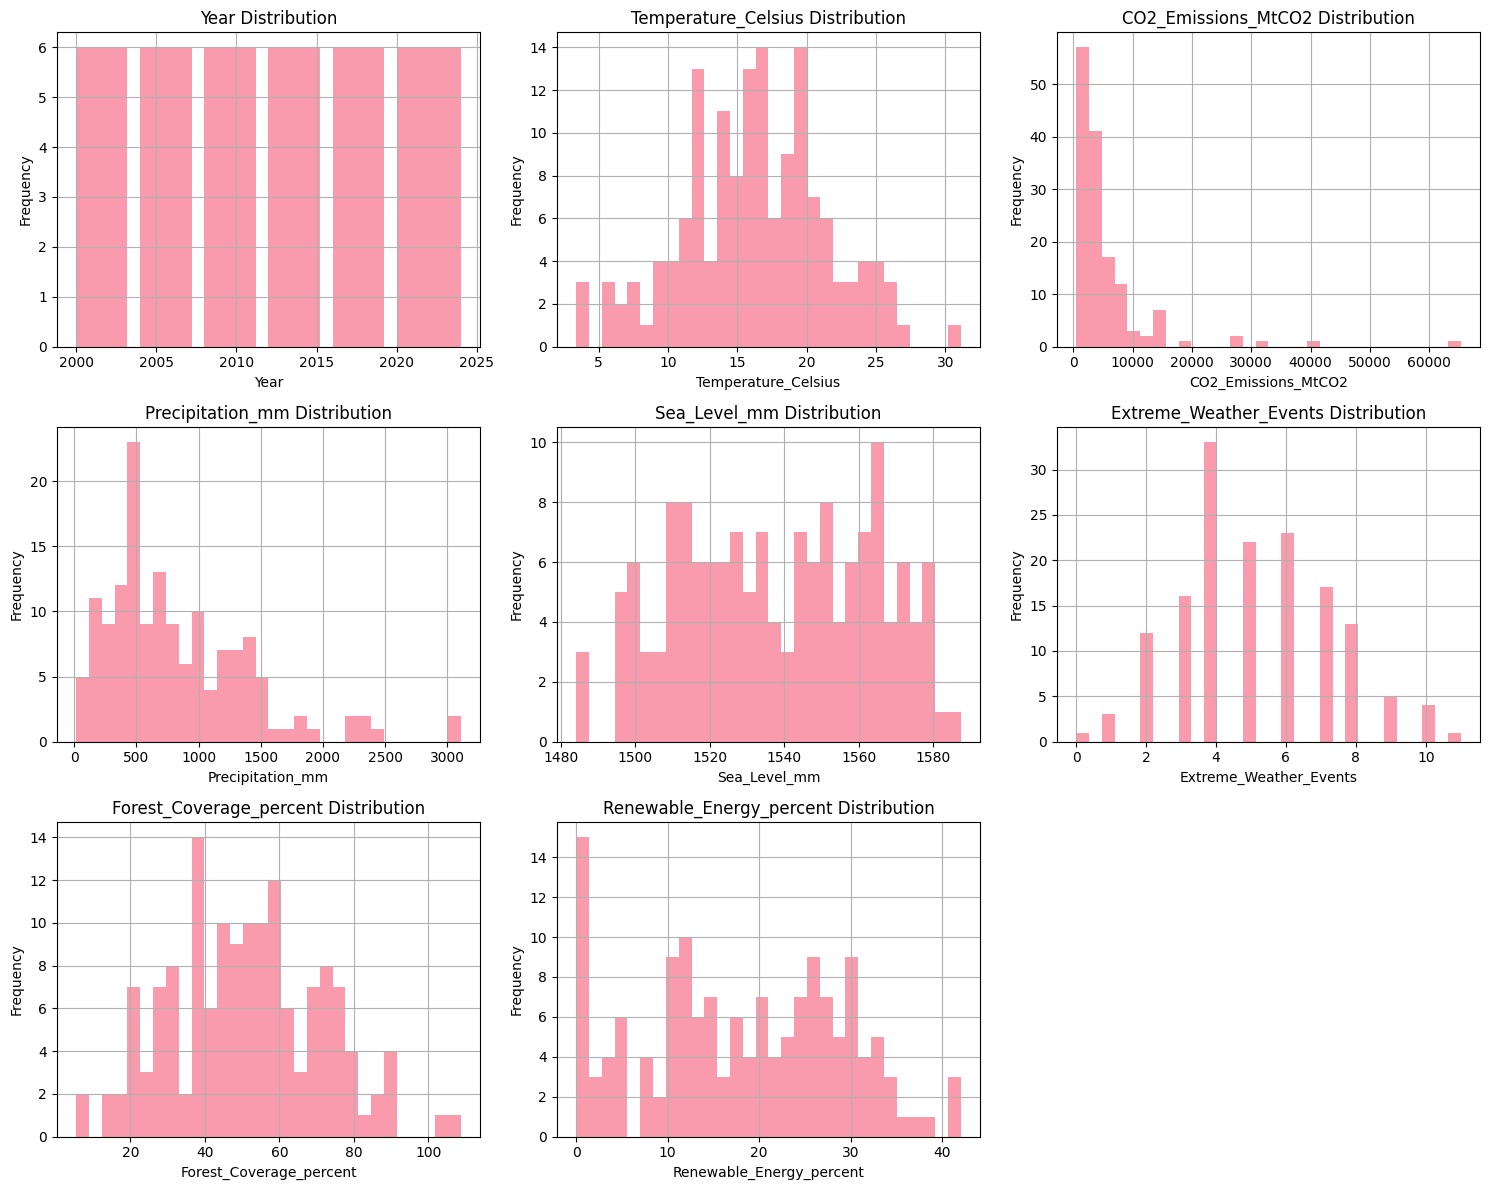


2. CORRELATION ANALYSIS
------------------------------


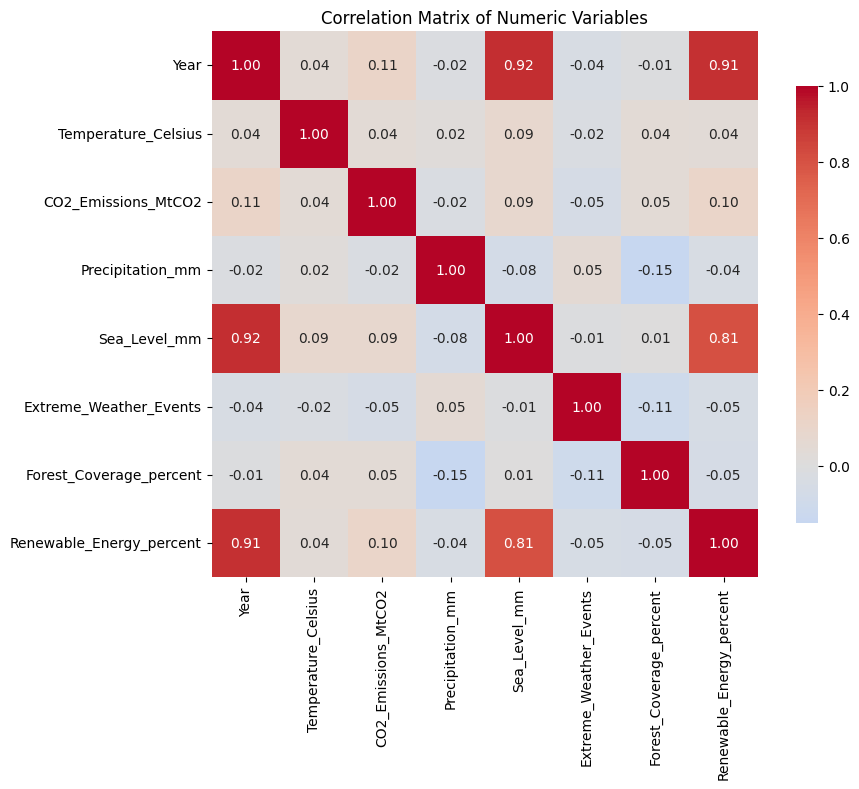


High Correlations (>0.7):
   Year ↔ Sea_Level_mm: 0.917
   Year ↔ Renewable_Energy_percent: 0.909
   Sea_Level_mm ↔ Renewable_Energy_percent: 0.807

3. TIME SERIES TRENDS
------------------------------


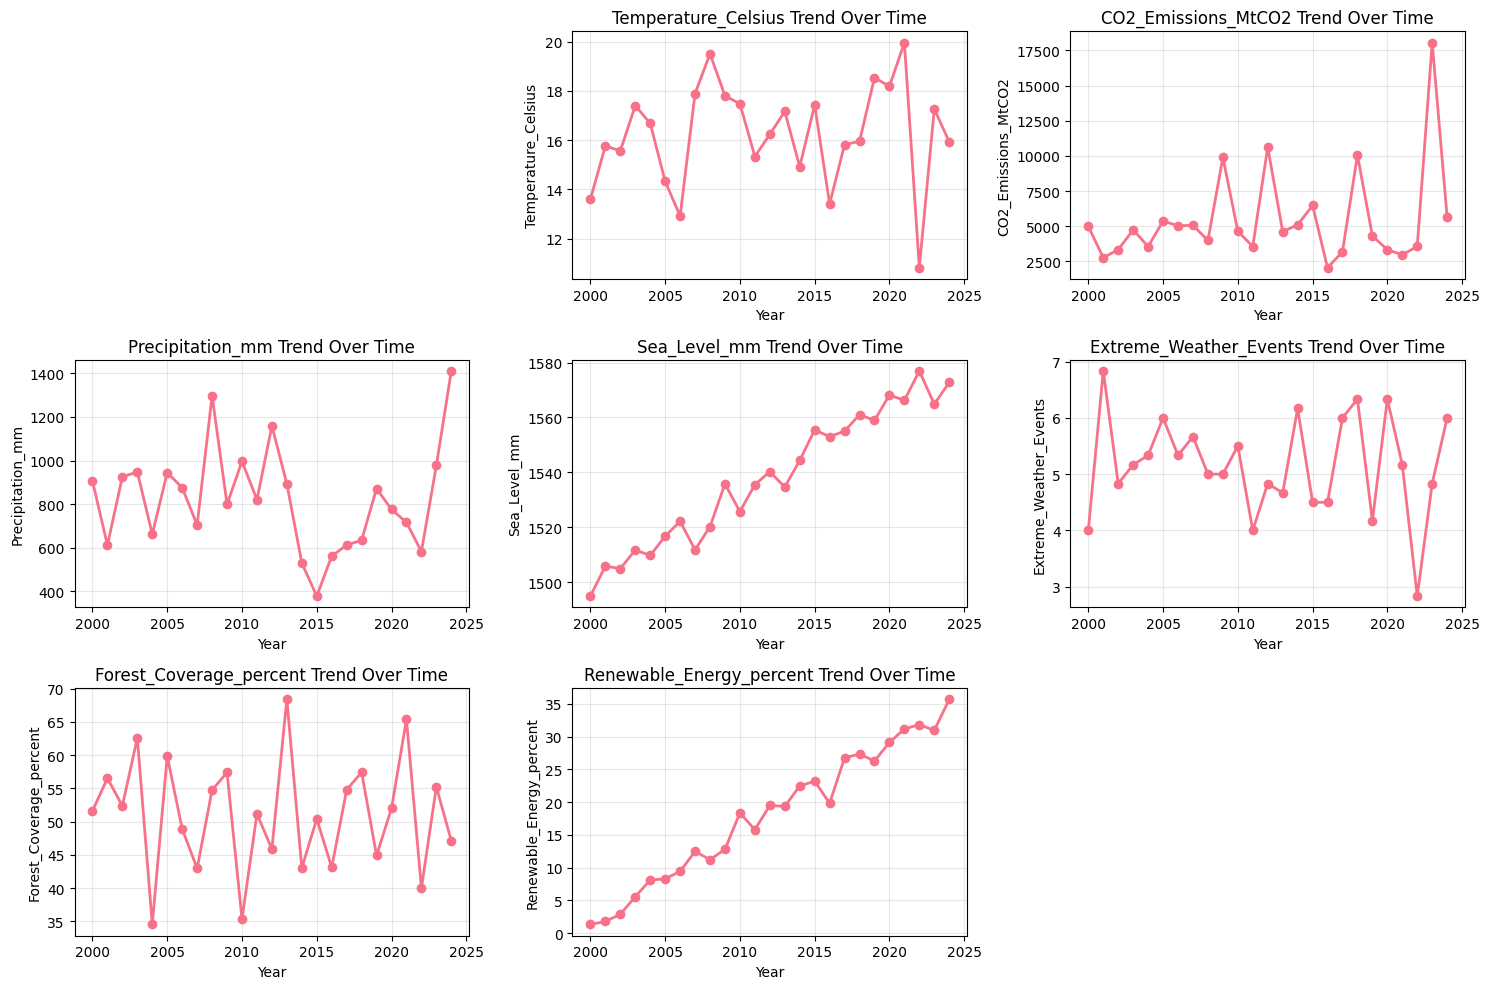


4. OUTLIER DETECTION
------------------------------
                  Column  Outliers_Count  Outliers_Percentage  Lower_Bound  Upper_Bound
                    Year               0             0.000000  1988.000000  2036.000000
     Temperature_Celsius               1             0.666667     1.898764    30.249405
     CO2_Emissions_MtCO2              15            10.000000 -4052.353345 11557.540767
        Precipitation_mm               5             3.333333  -646.361488  2235.228762
            Sea_Level_mm               0             0.000000  1452.597963  1624.961705
  Extreme_Weather_Events               0             0.000000    -0.500000    11.500000
 Forest_Coverage_percent               1             0.666667    -3.341330   106.711269
Renewable_Energy_percent               0             0.000000   -14.614117    51.739054

DATA TRANSFORMATION

1. HANDLING MISSING VALUES
-----------------------------------
   CO2_Emissions_MtCO2: Filled with median (3312.23)
   Forest_Coverag

In [10]:
if __name__ == "__main__":
    df_final, summary = main()